In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
from collections import defaultdict
import os
import matplotlib 
import matplotlib.pyplot as plt 
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")


In [3]:
# ### ATTENTION - LEAVE THIS SECTION COMMENTED

# ### This section is only to be used for deleting all Trace files in Trace Folders.
# ### Only uncomment this section if you want to delete your Trace files.
# ### Regenerating deleted Traces files is a lengthy task.
# ### How to use this section delete Trace files:
# ###     - uncomment this section  (ctrl + A) -> (ctrl + /)
# ###     - Verify correct choice for COLAB = True/False
# ###     - run only this section   (shift + enter)
# ###     - re-comment this section  (ctrl + A) -> (ctrl + /)

# def delete_trace_files():
#     # COLAB = True
#     COLAB = False

#     if COLAB:
#         from google.colab import drive
#         drive.mount('/content/drive', force_remount=True)
#         dirs = ["/content/drive/MyDrive/Bayes_ISFET/TracesLogistic", "/content/drive/MyDrive/Bayes_ISFET/TracesLogistic_ph",
#                 "/content/drive/MyDrive/Bayes_ISFET/TracesLogistic_stab", "/content/drive/MyDrive/Bayes_ISFET/TracesExponential", "/content/drive/MyDrive/Bayes_ISFET/TracesExponential_ph", "/content/drive/MyDrive/Bayes_ISFET/TracesExponential_stab"]
#     else:
#         dirs = ["TracesLogistic", "TracesLogistic_ph",
#                 "TracesLogistic_stab", "TracesExponential", "TracesExponential_ph", "TracesExponential_stab"]
#     for d in dirs:
#         for file in os.listdir(d):
#             if ".csv" in str(file):
#                 os.remove(os.path.join(d, file))

# delete_trace_files()


In [4]:
# This section reads in the ISFET_CVCC.txt file and converts it into a pandas dataframe
import re

def convert_txt_to_df(file):
    with open(file, "r") as f:
        # Intantiate dictionary and its sub dictionaries
        ph_data = {}
        ph_data['Voltage'] = []
        ph_data['ph'] = []
        ph_data['Temperature'] = []
        f.readline()
        for line in f:
            # check for temp discontinuation in file, and update temp variable
            if "Information" in line:
                temp = line[21:23]
                continue
            # remove tab and newline characters
            line = re.sub(r"\s+", " ", line)
            # Delimit string into two list items by space
            items = line.split()
            voltage = items[0]
            ph = items[1]
            ph_data['Voltage'].append(float(voltage))
            ph_data['ph'].append(float(ph))
            ph_data['Temperature'].append(int(temp))
    return pd.DataFrame.from_dict(ph_data)


In [5]:
import torch
import random

USE_CUDA = torch.cuda.is_available()
seed = 53113
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if USE_CUDA:
    DEVICE = torch.device('cuda')
    torch.cuda.manual_seed(seed)
    print("Using cuda.")
else:
    DEVICE = torch.device('cpu')
    print("Using cpu.")

while True:
    inpt = input(f"Are you running on Google Colab (Recommended)? (y/n)")
    if inpt == ("y" or "Y"):
        print("Running on Google Colab...")
        COLAB = True
        break
    elif inpt == ("n" or "N"):
        print("Running on local machine...")
        COLAB = False
        break
    else:
        print("Invalid response. Please type y or n.")

while True:
    inpt = input(f'''Please select the logistic or exponential fitting method. 
    (l/e) (l = logistic : e = exponential)''')
    if inpt == ("l" or "L"):
        print("logistic chosen.")
        LOGISTIC = True
        traces_folder = "TracesLogistic"
        break
    elif inpt == ("e" or "E"):
        print("exponential chosen.")
        LOGISTIC = False
        traces_folder = "TracesExponential"
        break
    else:
        print("Invalid response. Please type l or e.")

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    PATH = "/content/drive/MyDrive/Bayes_ISFET/Data_ISFET"
    temporal_data = pd.read_excel(
        'drive/MyDrive/Bayes_ISFET/Data_ISFET/Temporal data.xlsx')
    ph_data = convert_txt_to_df(
        'drive/MyDrive/Bayes_ISFET/Data_ISFET/ISFET_CVCC.txt')
    stab_data = pd.read_csv(
        'drive/MyDrive/Bayes_ISFET/Data_ISFET/Stabilization data.csv')
    if not os.path.exists(f'drive/MyDrive/Bayes_ISFET/{traces_folder}'):
        os.makedirs(f'drive/MyDrive/Bayes_ISFET/{traces_folder}')
    if not os.path.exists(f'drive/MyDrive/Bayes_ISFET/{traces_folder}_ph'):
        os.makedirs(f'drive/MyDrive/Bayes_ISFET/{traces_folder}_ph')
    if not os.path.exists(f'drive/MyDrive/Bayes_ISFET/{traces_folder}_stab'):
        os.makedirs(f'drive/MyDrive/Bayes_ISFET/{traces_folder}_stab')
else:
    temporal_data = pd.read_excel(
        'Data_ISFET/Temporal data.xlsx')
    ph_data = convert_txt_to_df(
        'Data_ISFET/ISFET_CVCC.txt')
    stab_data = pd.read_csv('Data_ISFET/Stabilization data.csv')
    if not os.path.exists(f'./{traces_folder}'):
        os.makedirs(f'./{traces_folder}')
    if not os.path.exists(f'./{traces_folder}_ph'):
        os.makedirs(f'./{traces_folder}_ph')
    if not os.path.exists(f'./{traces_folder}_stab'):
        os.makedirs(f'./{traces_folder}_stab')
# Temperature range
Temps_temporal = [15, 25, 30, 35, 40, 45]
Temps_ph = [15, 25, 30, 35, 40, 45]

try:
    for T in Temps_temporal:
      if COLAB:
        pd.read_csv(f'drive/MyDrive/Bayes_ISFET/{traces_folder}/{T}_trace.csv', index_col=0)
      else:
        file = pd.read_csv(f'{traces_folder}/{T}_trace.csv', index_col=0)
    print("Traces found in folder. No need to specify samples.")
    print("Numpber of Samples: ", int(len(file)/4))
    num_samples = int(len(file) / 4)
except:
    while True:
        print('''This machine learning model randomly samples values from various statistical distributions. 
Generally, a model's prediciton accuracy more closely aligns with reality as the number of samples increases,
but there is an unspecified "happy medium" between number of samples and computation time.''')
        num_samples = int(
            input(f'''How many samples? 
200k ~ 30 mins, 20k ~ 3 mins, 2.5k ~ 1 min 
(run-times assuming the use of Google Colab)
'''))
        if isinstance(num_samples, int):
            if num_samples > 0:
                break
        else:
            print("Please enter a positive integer.")

Using cpu.
Running on local machine...
logistic chosen.
This machine learning model randomly samples values from various statistical distributions. 
Generally, a model's prediciton accuracy more closely aligns with reality as the number of samples increases,
but there is an unspecified "happy medium" between number of samples and computation time.


In [6]:
import theano
theano.__version__
run_inference=True
temporal_data

,time,V(vref),Temperature
0,0.000000,5.790837,15
1,229.001459,5.791682,15
2,459.000006,5.792004,15
3,688.664300,5.792239,15
4,910.053687,5.792425,15
...,...,...,...
9927,42557.664300,19.546850,65
9928,42780.000000,19.546870,65
9929,43009.001459,19.546890,65
9930,43198.664300,19.546910,65


In [7]:
ph_data

,Voltage,ph,Temperature
0,0.0,3.749425,15
1,0.1,3.755151,15
2,0.2,3.760878,15
3,0.3,3.766604,15
4,0.4,3.772331,15
...,...,...,...
5776,13.6,4.389878,55
5777,13.7,4.396399,55
5778,13.8,4.402920,55
5779,13.9,4.409442,55


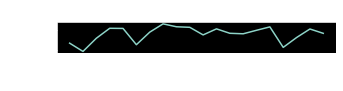

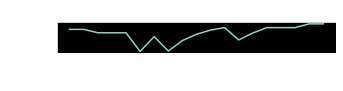

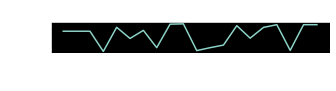

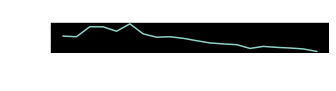

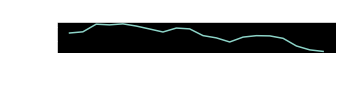

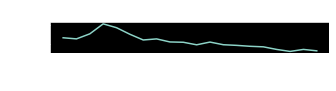

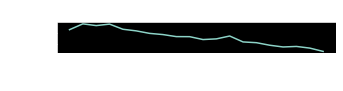

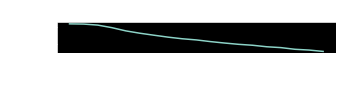

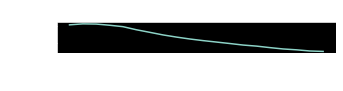

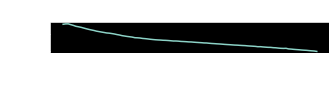

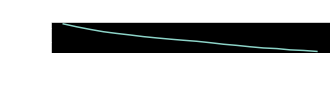

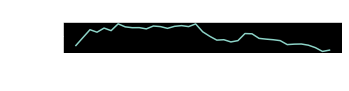

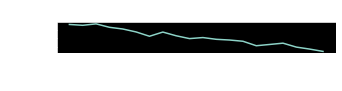

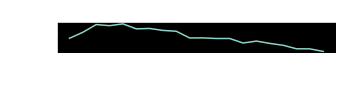

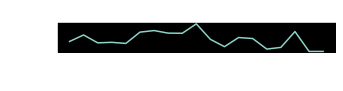

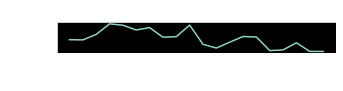

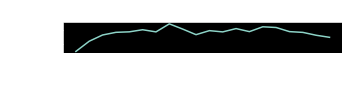

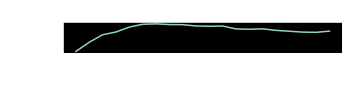

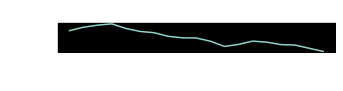

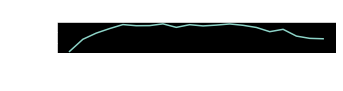

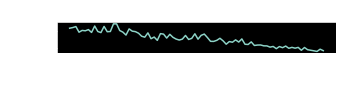

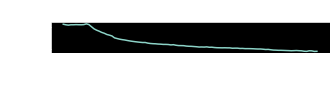

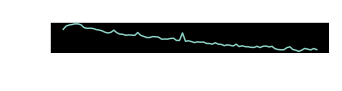

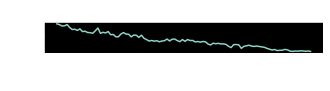

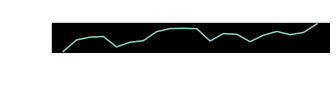

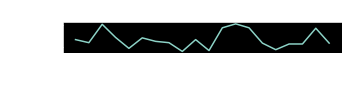

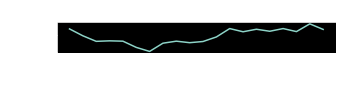

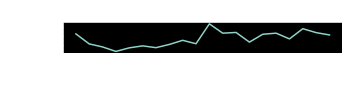

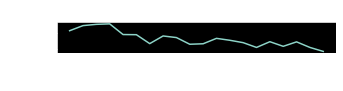

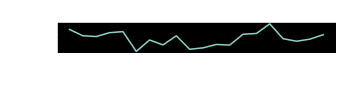

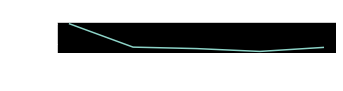

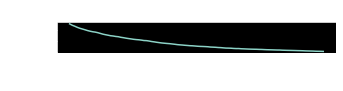

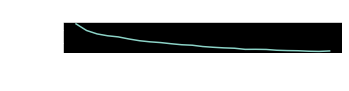

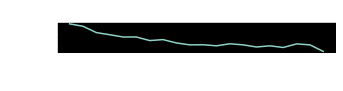

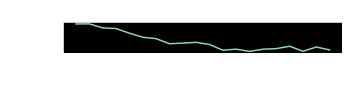

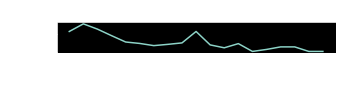

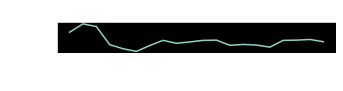

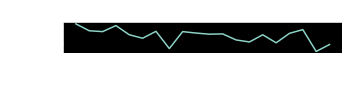

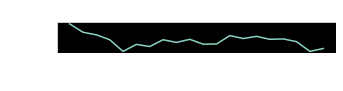

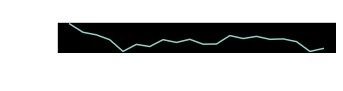

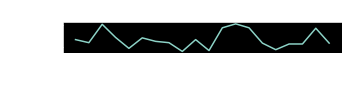

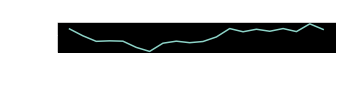

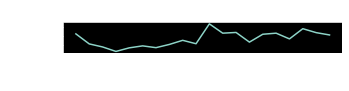

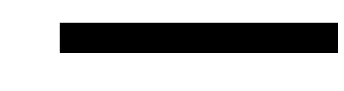

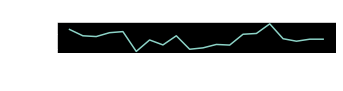

In [93]:
df = stab_data
stab_data = defaultdict()
stab_data['Time'] = df.Time.to_list()
skip = False
for col in df.columns[1:]:
    key = col
    stab_data[key] = []
    for string in df[col].to_list():
        if not isinstance(string, float):  # if not nan
            string = string.replace("/", "_")
            for char in string:
                if ord('A') < ord(char) < ord('z'):
                    key = string
                    stab_data[key] = []
                    skip = True
                    break
            if not skip:
                stab_data[key].append(float(string))
            skip = False
    
count = 1
for string in list(stab_data.keys())[1:]:
    voltage = stab_data[string]
    time = stab_data['Time'][:len(voltage)]
    fig = plt.figure(figsize=(5, 30))
    plt.subplot(len(stab_data.keys())-1, 1, count)
    plt.plot(time, voltage)
    plt.title(f"Voltage vs Time: {string}")
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    count += 1


      Time pbs_2 Voltage pbs_dri_1 Voltage pbs_dr1 Voltage pbs_1 Voltage
0  0.33333       1.47301           1.50092         1.55417       1.61274
1  0.66667       1.47376           1.49939         1.55511       1.60264
2  1.00000       1.47347           1.49721         1.55654       1.59373
3  1.33333       1.45742           1.49753         1.54837       1.58561
4  1.66667       1.47109           1.49496         1.55098       1.57966
  pbs_dri1 Voltage pbs_dri_1 Voltage.1 pbs_dri1 Voltage.1 pbs_18 Voltage
0          1.78285             1.66619            1.73787        1.42628
1          1.77628             1.66166            1.73481        1.42661
2           1.7723             1.65327             1.7326         1.4268
3          1.77634              1.6545            1.73004        1.42692
4          1.77628             1.66206            1.72792        1.42649
  pbs_9 Voltage pbs_13 Voltage pbs_3 Voltage pbs3 Voltage
0       1.46083        1.41881       1.54455      1.65712
1       

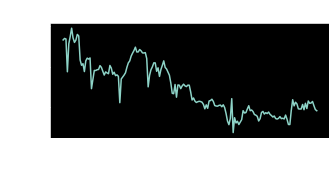

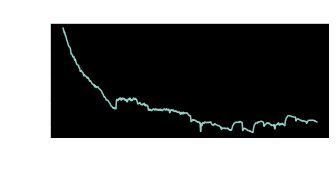

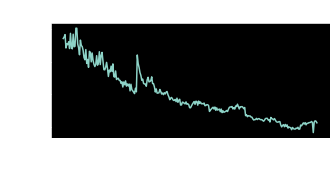

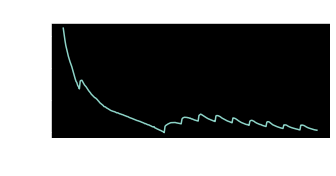

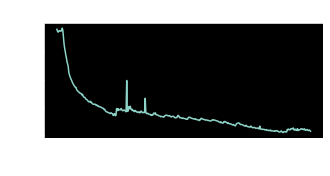

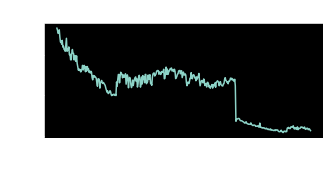

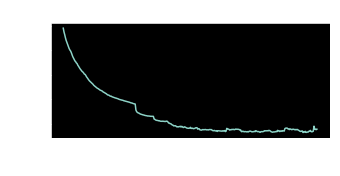

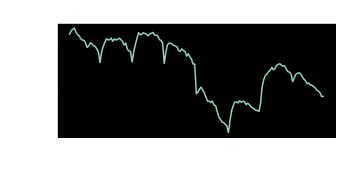

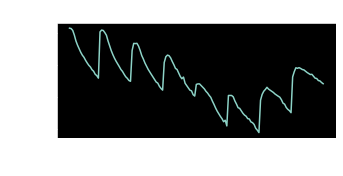

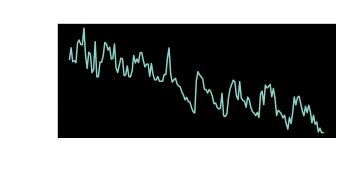

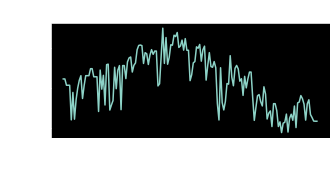

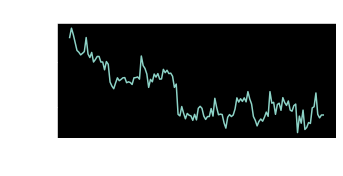

In [12]:
# df = stab_data
# print(df[df.columns[0:5]].head(5))
# print(df[df.columns[5:9]].head(5))
# print(df[df.columns[9:14]].head(5))
# df.replace([r'^(?![0-9]+[.][0-9]+)'], np.NaN, regex=True, inplace=True)
# stab_data = defaultdict()
# stab_data['Time'] = df.Time.to_list()
# for col in df.columns[1:]:
#     stab_data[col] = []
#     for p in df[col].to_list():
#         if not isinstance(p, float):
#             stab_data[col].append(float(p))
# count = 1
# for p in list(stab_data.keys())[1:]:
#     voltage = stab_data[p]
#     time = stab_data['Time'][:len(voltage)]
#     fig = plt.figure(figsize=(5, 30))
#     plt.subplot(len(stab_data.keys())-1, 1, count)
#     plt.plot(time, voltage)
#     plt.title(f"Voltage vs Time: {p}")
#     plt.xlabel('Time')
#     plt.ylabel('Voltage')
#     count += 1

In [ ]:
# Convert the times from string to float
temporal_data['time'] = temporal_data['time'].astype(float)

# adding a column of minutes in the data
mins = []
for r in range(len(temporal_data)):
    mins.append(temporal_data.iloc[r]['time']//60)
temporal_data['minute'] = mins
temporal_data.dtypes


In [ ]:
count = 1
for T in Temps_temporal:
    time = temporal_data[temporal_data['Temperature'] == T]['minute']
    vref = temporal_data[temporal_data['Temperature'] == T]['V(vref)']
    fig = plt.figure(figsize=(5, 30))
    plt.subplot(len(Temps_temporal), 1, count)
    plt.plot(time, vref)
    plt.title("Vref vs Time at Temperature:%s" % T)
    plt.xlabel('Time(minutes)')
    plt.ylabel('Vref(V)')
    count += 1

In [ ]:
count = 1
for T in Temps_ph:
    voltage = ph_data[ph_data['Temperature'] == T]['Voltage']
    ph = ph_data[ph_data['Temperature'] == T]['ph']
    fig = plt.figure(figsize=(5, 30))
    plt.subplot(len(Temps_ph), 1, count)
    plt.plot(voltage, ph)
    plt.title("pH vs Voltage at Temperature:%s" % T)
    plt.xlabel('pH')
    plt.ylabel('Voltage')
    count += 1

In [ ]:
# Logistic Values
logistic_parameters = {
    "15": {"A1": 5.79, "A2": 5.82, "t0": 5031, "p": 0.466},
    "25": {"A1": 5.82, "A2": 5.93, "t0": 1066, "p": 0.497},
    "30": {"A1": 5.84, "A2": 6.05, "t0": 474, "p": 0.556},
    "35": {"A1": 5.86, "A2": 6.26, "t0": 211, "p": 0.522},
    "40": {"A1": 5.88, "A2": 6.63, "t0": 98, "p": 0.604},
    "45": {"A1": 5.93, "A2": 7.28, "t0": 49, "p": 0.665}}

def inferring_parameters(parameter1, parameter2, iteration, curve="r"):
    '''
    https://docs.pymc.io/notebooks/getting_started.html

    Initializing model
    Vref = epsilon - alpha * exp(-beta*time) # exponential
    Vref = A2 + (A1 - A2)/(1 + e^(p * ln (voltage/v0))   # logistic

    To conduct Markov chain Monte Carlo (MCMC) sampling to generate posterior samples in PyMC3, we specify a step method object that 
    corresponds to a particular MCMC algorithm, such as Metropolis, Slice sampling, or the No-U-Turn Sampler (NUTS). PyMC3’s step_methods 
    submodule contains the following samplers: NUTS, Metropolis, Slice, HamiltonianMC, and BinaryMetropolis. These step methods can be 
    assigned manually, or assigned automatically by PyMC3. Auto-assignment is based on the attributes of each variable in the model. In general:
        Binary variables will be assigned to BinaryMetropolis
        Discrete variables will be assigned to Metropolis
        Continuous variables will be assigned to NUTS

    curve: "r" is increasing at a decreasing rate
           "l" is decreasing at a decreasing rate
    '''
    model_isfet = pm.Model()
    with model_isfet:
        if curve == "r":
            if LOGISTIC:
                t0 = logistic_parameters[str(iteration)]["t0"]
                A1 = pm.Uniform('A1', 0, 10)
                A2 = pm.Uniform('A2', 0, 10)
                p = pm.Uniform('p', 0.4, 0.7)
                mu = A2 + (A1 - A2)/(1 + np.exp(p*np.log(parameter1 / t0)))
            else:
                alpha = pm.Uniform('alpha', 0, 1)
                beta = pm.Uniform('beta', 0, 0.1)
                epsilon = pm.Uniform('epsilon', 4, 10)
                mu = epsilon-alpha*np.exp(-beta*parameter1)
        elif curve == "l": # used for stabilization data 
                alpha = pm.Uniform('alpha', 0, 1)
                beta = pm.Uniform('beta', 0, 1)
                epsilon = pm.Uniform('epsilon', 0, 2)
                mu = epsilon+alpha*np.exp(-beta*parameter1)
        else:
            print("curve undefined")

        sd = pm.Uniform('sd', 0, 1)

        # Likelihood (sampling distribution) of observations
        parameter = pm.Normal('parameter', mu=mu,
                              sigma=sd, observed=parameter2)
        # Model Fitting
        step = pm.Metropolis()
        trace = pm.sample(num_samples, step=step)
    return trace


In [ ]:
#Loading traces
Traces = {}
try:
    for T in Temps_temporal:
        if COLAB:
            Traces[T] = pd.read_csv(
                f'drive/MyDrive/Bayes_ISFET/{traces_folder}/{T}_trace.csv', index_col=0)
        else:
            Traces[T] = pd.read_csv(
                f'{traces_folder}/{T}_trace.csv', index_col=0)
    print("Saved traces found!!!")
except:
    print("Saved traces not found, starting inference")
    if run_inference == True:
        for T in Temps_temporal:
            print("Working on Temperaure:", T)
            time = temporal_data[temporal_data['Temperature'] == T]['minute']
            vref = temporal_data[temporal_data['Temperature'] == T]['V(vref)']
            trace = inferring_parameters(time, vref, T)
            Traces[T] = trace
        for k in Traces.keys():
            trace_data = pm.backends.tracetab.trace_to_dataframe(Traces[k])
            if COLAB:
                trace_data.to_csv(
                    f'drive/MyDrive/Bayes_ISFET/{traces_folder}/{k}_trace.csv')
            else:
                trace_data.to_csv(f'{traces_folder}/{k}_trace.csv')
            print('saved traces!')


In [ ]:
# Inferred-Posterior histograms
count = 0

for T in Temps_temporal:
    fig = plt.figure(figsize=(10, 10))

    if LOGISTIC:
        A1_samples = Traces[T]["A1"][num_samples//2:]
        A2_samples = Traces[T]["A2"][num_samples//2:]
        p_samples = Traces[T]["p"][num_samples//2:]
        # histogram of the samples:
        plt.subplot(11, 3, 3*count+1)
        plt.title(
            r"Temperature:%s--Posterior distributions of the variables␣,→$A_1$ and $A_2$" % T)
        plt.hist(A1_samples, histtype='stepfilled', bins=35, alpha=0.85,
                 label=r"posterior of $A_1$", color="#A60628", density=True)
        plt.legend()
        plt.subplot(11, 3, 3*count+2)
        plt.hist(A2_samples, histtype='stepfilled', bins=35, alpha=0.85,
                 label=r"posterior of $A_2$", color="#7A68A6", density=True)
        plt.legend()
        plt.subplot(11, 3, 3*count+2)
        plt.hist(p_samples, histtype='stepfilled', bins=35, alpha=0.85,
                 label=r"posterior of $p$", color="#A60628", density=True)
        plt.legend()
    else:
        alpha_samples = Traces[T]["alpha"][num_samples//2:]
        beta_samples = Traces[T]["beta"][num_samples//2:]
        epsilon_samples = Traces[T]["epsilon"][num_samples//2:]
        # histogram of the samples:
        plt.subplot(11, 3, 3*count+1)
        plt.title(
            r"Temperature:%s--Posterior distributions of the variables␣,→$\alpha$, $\beta$, and $\epsilon$" % T)
        plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
                 label=r"posterior of $\alpha$", color="#A60628", density=True)
        plt.legend()
        plt.subplot(11, 3, 3*count+2)
        plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
                 label=r"posterior of $\beta$", color="#7A68A6", density=True)
        plt.legend()
        plt.subplot(11, 3, 3*count+3)
        plt.hist(epsilon_samples, histtype='stepfilled', bins=35, alpha=0.85,
                 label=r"posterior of $\epsilon$", color="#A60628", density=True)
        plt.legend()

    count += 1


In [ ]:
# Plotting compensated vs uncompensated
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error 
Te=[]
ev=[]
r2=[]
mse=[]
mae=[]
count=1
for T in Temps_temporal:
    if LOGISTIC:
        A1_samples = Traces[T]["A1"][num_samples//2:]
        A2_samples = Traces[T]["A2"][num_samples//2:]
        p_samples = Traces[T]["p"][num_samples//2:]
        A1_mean=A1_samples.mean()
        A2_mean=A2_samples.mean()
        p_mean=p_samples.mean()
        t0_mean = sum([logistic_parameters[str(T)]["t0"]
                       for T in Temps_temporal])/len(Temps_temporal)
    else:
        alpha_samples=Traces[T]["alpha"][num_samples//2:]
        beta_samples=Traces[T]["beta"][num_samples//2:]
        epsilon_samples=Traces[T]["epsilon"][num_samples//2:]
        epsilon_mean=epsilon_samples.mean()
        alpha_mean=alpha_samples.mean()
        beta_mean=beta_samples.mean()
    try:
        time = temporal_data[temporal_data['Temperature'] == T]['minute']
        vref = temporal_data[temporal_data['Temperature'] == T]['V(vref)']
    except:
        time = temporal_data[temporal_data['Temperature'] == T]['minute']
        vref = temporal_data[temporal_data['Temperature'] == T]['V(vref)']
    #predicted
    if LOGISTIC:
        vref_pred = A2_mean + (A1_mean - A2_mean)/(1 + np.exp(p_mean*np.log(time / t0_mean)))
    else:
        vref_pred = epsilon_mean - alpha_mean * np.exp(-beta_mean * time)
    fig=plt.figure(figsize=(5,30))
    plt.subplot(11,1,count)
    plt.title(f"Temperature:{T}")
    plt.xlabel('$Time (minutes)$')
    plt.ylabel('Vref (V)')
    plt.plot(time, vref, 'r', label="True")
    plt.plot(time, [vref_pred.iloc[0]+vref.iloc[i]-vref_pred.iloc[i] for i in range(len(vref))], 'g', label="Predicted")
    plt.legend()
    plt.grid()
    
    #Errors
    Te.append(T)
    ev.append(explained_variance_score(vref, vref_pred))
    r2.append(r2_score(vref, vref_pred))
    mse.append(mean_squared_error(vref, vref_pred))
    mae.append(mean_absolute_error(vref, vref_pred))

    count += 1

# Saving the results
errors=pd.DataFrame()
errors['Temperature']=Te
errors['Explained_variance']=ev
errors['R2']=r2
errors['MSE']=mse
errors['MAE']=mae

errors.to_csv('TemporalResults.csv')


In [ ]:
print(errors)

In [ ]:
#Loading traces
Traces = {}
try:
    for T in Temps_ph:
        if COLAB:
            Traces[T] = pd.read_csv(
                f'drive/MyDrive/Bayes_ISFET/{traces_folder}_ph/{T}_trace_ph.csv', index_col=0)
        else:
            Traces[T] = pd.read_csv(
                f'{traces_folder}_ph/{T}_trace_ph.csv', index_col=0)
    print("Saved traces found!!!")
except:
    print("Saved traces not found, starting inference")
    if run_inference == True:
        for T in Temps_ph:
            print("Working on Temperaure:", T)
            voltage = ph_data[ph_data['Temperature'] == T]['Voltage']
            ph = ph_data[ph_data['Temperature'] == T]['ph']
            trace = inferring_parameters(voltage, ph, T)
            Traces[T] = trace
        for k in Traces.keys():
            trace_data = pm.backends.tracetab.trace_to_dataframe(Traces[k])
            if COLAB:
                trace_data.to_csv(
                    f'drive/MyDrive/Bayes_ISFET/{traces_folder}_ph/{k}_trace_ph.csv')
            else:
                trace_data.to_csv(f'{traces_folder}_ph/{k}_trace_ph.csv')
            print('saved traces!')

In [ ]:
# Plotting compensated vs uncompensated 
Te = []
ev = []
r2 = []
mse = []
mae = []
count = 1
for T in Temps_ph:
    if LOGISTIC:
        A1_samples = Traces[T]["A1"][num_samples//2:]
        A2_samples = Traces[T]["A2"][num_samples//2:]
        p_samples = Traces[T]["p"][num_samples//2:]
        A1_mean = A1_samples.mean()
        A2_mean = A2_samples.mean()
        p_mean = p_samples.mean()
        v0_mean = sum([logistic_parameters[str(T)]["t0"] for T in Temps_ph])/len(Temps_ph)
    else:
        alpha_samples = Traces[T]["alpha"][num_samples//2:]
        beta_samples = Traces[T]["beta"][num_samples//2:]
        epsilon_samples = Traces[T]["epsilon"][num_samples//2:]
        epsilon_mean = epsilon_samples.mean()
        alpha_mean = alpha_samples.mean()
        beta_mean = beta_samples.mean()

    try:
        voltage = ph_data[ph_data['Temperature'] == T]['Voltage']
        ph = ph_data[ph_data['Temperature'] == T]['ph']
    except: 
        voltage = ph_data[ph_data['Temperature'] == T]['Voltage']
        ph = ph_data[ph_data['Temperature'] == T]['ph']

    if LOGISTIC:
        ph_pred = A2_mean + (A1_mean - A2_mean) / (1 + np.exp(p_mean*np.log(voltage / v0_mean)))
    else:
        ph_pred = epsilon_mean - alpha_mean * np.exp(-beta_mean * voltage)
    fig = plt.figure(figsize=(5, 30))
    plt.subplot(11, 1, count)
    plt.title(f"Temperature:{T}")
    plt.xlabel('$Voltage$')
    plt.ylabel('pH')
    plt.plot(voltage, ph, 'r', label="True")
    plt.plot(voltage, [ph_pred.iloc[0]+ph.iloc[i]-ph_pred.iloc[i]
                       for i in range(len(ph))], 'g', label="Predicted")
    plt.legend()
    plt.grid()

    # Errors
    Te.append(T)
    ev.append(explained_variance_score(ph, ph_pred))
    r2.append(r2_score(ph, ph_pred))
    mse.append(mean_squared_error(ph, ph_pred))
    mae.append(mean_absolute_error(ph, ph_pred))

    count += 1

# Saving the results
errors = pd.DataFrame()
errors['Temperature'] = Te
errors['Explained_variance'] = ev
errors['R2'] = r2
errors['MSE'] = mse
errors['MAE'] = mae
errors.to_csv("phResults.csv")

In [ ]:
print(errors)

In [ ]:
#Loading traces
Traces = {}
try:
    for p in list(stab_data.keys())[1:]:
        if COLAB:
            Traces[p] = pd.read_csv(
                f'drive/MyDrive/Bayes_ISFET/{traces_folder}_stab/{p}_trace_stab.csv', index_col=0)
        else:
            Traces[p] = pd.read_csv(
                f'{traces_folder}_stab/{p}_trace_stab.csv', index_col=0)
    print("Saved traces found!!!")
except:
    print("Saved traces not found, starting inference")
    if run_inference == True:
        for p in list(stab_data.keys())[1:]:
            print("Working on pH:", p)
            voltage = stab_data[p]
            time = stab_data['Time'][:len(voltage)]
            trace = inferring_parameters(time, voltage, p, curve="l")
            Traces[p] = trace
        for k in Traces.keys():
            trace_data = pm.backends.tracetab.trace_to_dataframe(Traces[k])
            if COLAB:
                trace_data.to_csv(
                    f'drive/MyDrive/Bayes_ISFET/{traces_folder}_stab/{k}_trace_stab.csv')
            else:
                trace_data.to_csv(f'{traces_folder}_stab/{k}_trace_stab.csv')
            print('saved traces!')


In [94]:
# Plotting compensated vs uncompensated for stabilization data
pH = []
ev = []
r2 = []
mse = []
mae = []
count = 1
for v in list(stab_data.keys())[1:]:
    alpha_samples = Traces[v]["alpha"][num_samples//2:]
    beta_samples = Traces[v]["beta"][num_samples//2:]
    epsilon_samples = Traces[v]["epsilon"][num_samples//2:]
    epsilon_mean = epsilon_samples.mean()
    alpha_mean = alpha_samples.mean()
    beta_mean = beta_samples.mean()
    try:
        voltage = np.array(stab_data[v])
        time = np.array(stab_data['Time'][:len(voltage)])
    except: 
        voltage = np.array(stab_data[v])
        time = np.array(stab_data['Time'][:len(voltage)])

    v_pred = epsilon_mean - alpha_mean * np.exp(-beta_mean * time)
    v_pred = pd.DataFrame(v_pred)

    fig = plt.figure(figsize=(5, 30))
    plt.subplot(len(list(stab_data.keys())[1:]), 1, count)
    plt.title(f"pH:{p}")
    plt.xlabel('$Time$')
    plt.ylabel('Voltage')
    plt.plot(time, voltage, 'r', label="True")
    plt.plot(time, [v_pred.iloc[0]+voltage[i]-v_pred.iloc[i]
                       for i in range(len(time))], 'g', label="Predicted")
    plt.legend()
    plt.grid()

    # Errors
    pH.append(p)
    if len(voltage) > 1:
        ev.append(explained_variance_score(voltage, v_pred))
        r2.append(r2_score(voltage, v_pred))
        mse.append(mean_squared_error(voltage, v_pred))
        mae.append(mean_absolute_error(voltage, v_pred))
    else:
        ev.append(1.0)
        r2.append(1.0)
        mse.append(1.0)
        mae.append(1.0)

    count += 1

# Saving the results
errors = pd.DataFrame()
errors['pH'] = pH
errors['Explained_variance'] = ev
errors['R2'] = r2
errors['MSE'] = mse
errors['MAE'] = mae
errors.to_csv("stabResults.csv")


NameError: name 'Traces' is not defined